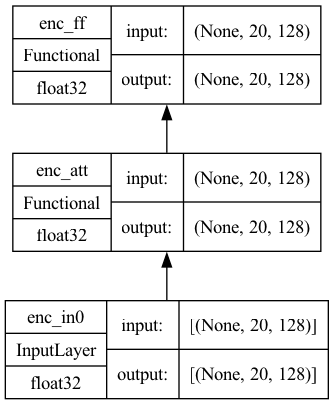

In [2]:
import nbimporter
import tensorflow as tf

# the building block functions from sub-models
from sub_models import self_attention, feed_forward

def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """
    One encoder unit. The input and output are in the same shape so we can 
    daisy chain multiple encoder units into one larger encoder
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model

seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png", show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='BT', show_layer_activations=True)

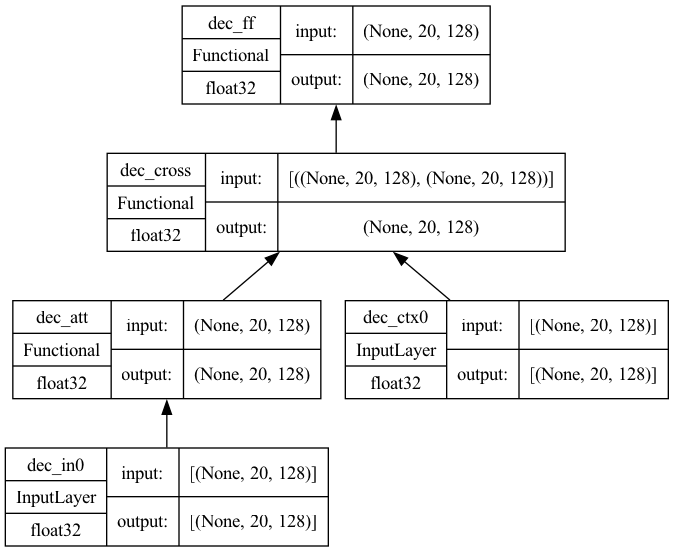

In [3]:
import tensorflow as tf

# the three building block functions from sub_models
from sub_models import self_attention, cross_attention, feed_forward


def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """
    One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience.
    """
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True, prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim, prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model

seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png", show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='BT', show_layer_activations=True)